# Serif Health Data Science Takehome
Author: Kara Feilich
Date Created: 2025MAR14
Date Last Modified: 2025MAR14

Description:



In [283]:
import pandas as pd

import seaborn as sns


import sys


In [284]:
print(sys.version)
print(pd.__version__)

pd.set_option('display.max_rows', 1000)

3.11.7 (main, Dec 15 2023, 12:09:56) [Clang 14.0.6 ]
2.1.4


### 0. Import and inspect data
I know I want to join on at least 
* payer_name = payer,
* plan_name = network_name (or a combination of network name and payer) (Ideally, would like to join on network_id or plan_id... there aren't enough keys)
* code_type = code_type
* raw_code = code

**PROBLEM: The prompt made it sound like I could find "facility" in the payer file, and I cannot for the life of me. This is causing a major problem**

In [286]:
hospitals = pd.read_csv("data/hpt_extract_20250213.csv")
hospitals.columns

Index(['source_file_name', 'hospital_id', 'hospital_name', 'last_updated_on',
       'hospital_state', 'license_number', 'payer_name', 'plan_name',
       'code_type', 'raw_code', 'description', 'setting', 'modifiers',
       'standard_charge_gross', 'standard_charge_discounted_cash',
       'standard_charge_negotiated_dollar',
       'standard_charge_negotiated_percentage', 'standard_charge_min',
       'standard_charge_max', 'standard_charge_methodology',
       'additional_payer_notes', 'additional_generic_notes'],
      dtype='object')

In [287]:
payers = pd.read_csv("data/tic_extract_20250213.csv")
payers.columns

Index(['payer', 'network_name', 'network_id', 'network_year_month',
       'network_region', 'code', 'code_type', 'ein',
       'taxonomy_filtered_npi_list', 'modifier_list', 'billing_class',
       'place_of_service_list', 'negotiation_type', 'arrangement', 'rate',
       'cms_baseline_schedule', 'cms_baseline_rate'],
      dtype='object')

Lets look at the unique values in the join fields, to see if I can preempt some issues.

In [289]:
print(f'Payers unique combinations: {payers[["payer","network_name"]].value_counts()}')
print()
print(f'Hospitals unique combinations: {hospitals[["payer_name", "plan_name"]].value_counts()}')
 
# Add some blank lines
print()
print()


Payers unique combinations: payer              network_name              
aetna              open-access-managed-choice    133
unitedhealthcare   choice-plus                    45
cigna-corporation  national-oap                   44
Name: count, dtype: int64

Hospitals unique combinations: payer_name                 plan_name                                                                    
Aetna                      Medicare                                                                         12
Multiplan                  Complementary Network                                                            10
                           Primary Network                                                                  10
Emblem                     Select Care                                                                      10
                           GHI Network Access                                                               10
Magnacare                  Standard              

In the payers table, there are only 3 unique combinations of payer and network name: "unitedhealthcare,choice-plus", "aetna,open-access-managed-choice", and "cigna-corporation, national-oap".

But in the hospitals table, it's a mess. And United and Cigna are encoded differently. This makes sense. Every facility probably uses its own data entry conventions, and they may not match up. So part of what I have to do is build or force a synonymy. (Aside-- this is an argument for Serif to build an ETL pipeline for a common data model.)

**Assumption 1: I am not messing with any of the data values (e.g. making any artificially equivalent) by putting them all in lowercase, and replacing any white space with underscores.  
Justification 1: I already see there are formatting issues, and this will at least standardize them a little.**

In [304]:
for col in hospitals.columns:
    if hospitals[col].dtype == 'object':  # Check if the column is of type 'object' (string)
        hospitals[col] = hospitals[col].str.lower().str.replace(' ', '_')


for col in payers.columns:
    if payers[col].dtype == 'object':  # Check if the column is of type 'object' (string)
        payers[col] = payers[col].str.lower().str.replace(' ', '_')

## Found later-- apparently 'code' vs 'raw_code' is a string in one dataframe and an int in another. 
## For the sake of determining why, we're going to cast to a string
payers['code'] = payers['code'].astype('string')
hospitals['raw_code'] = hospitals['raw_code'].astype('string')

In [306]:
hospitals[['payer_name','plan_name']].value_counts()


payer_name                 plan_name                                                                    
aetna                      medicare                                                                         12
emblem                     ghi_network_access                                                               10
                           select_care                                                                      10
multiplan                  primary_network                                                                  10
                           complementary_network                                                            10
magnacare                  standard                                                                          9
metroplus                  medicare_advantage                                                                8
                           exchange_products                                                                 8
       

OK, this is bad. I'm seeing a LOT of payers not represented in the hospital data at all--that's fine, I think the prompt suggested there were only three of the largest payers in the extract they provided. I'm going to exclude hospital rows that don't fall under one of those payers--and do my best not to miss any that do match.

**Assumption 2: There are no payers other than the three in the payers datset represented in the hospital data set that are actually owned by one of the three payers in the payer dataset.  
Justification 2: I don't have time to do a market scan of payers.**

In [328]:
hospitals.loc[hospitals['payer_name'].isin(['united', 'united-healthcare', 'united_healthcare']),'payer_name'] = 'united_healthcare'
hospitals.loc[hospitals['payer_name'] == 'cigna', 'payer_name'] =  'cigna-corporation'


In [330]:
hospitals[['payer_name']].value_counts()


payer_name               
hip                          392
medicare                     336
multiplan                    299
bcbs                         273
healthfirst                  169
metroplus                    153
aetna                        144
fidelis                      138
cigna-corporation            113
uhc                           93
ghi                           83
magnacare                     80
somos                         79
healthplus                    76
emblem                        72
empire                        50
medicaid                      42
centerlight                   33
oxford                        28
wellcare                      25
united_healthcare             23
1199                          20
beacon                        18
oscar                         16
affinity                      15
humana                        12
vnsny                         12
firsthealth                   12
elderplan                     10
mvp              

## 1. Try a naive left join and see what happens

In [332]:
test_merge1 = pd.merge(hospitals
         , payers
         , how='left'
         , left_on=['payer_name', 'plan_name','code_type','raw_code']
         , right_on=['payer','network_name', 'code_type', 'code']
                      )

In [334]:
test_merge1['payer_name'].unique()

array(['aetna', 'healthfirst', 'cigna-corporation', 'oscar', 'healthcare',
       'united_healthcare', 'emblem', 'humana', 'fidelis', 'centerlight',
       'partners', 'northwell', 'agewell', 'metroplus', 'longevity',
       'mvp', 'hamaspik', 'wellcare', 'empire', 'elderplan', 'vnsny',
       'nat', 'centersplan', 'uhc', 'villagecaremax', 'senior', 'nippon',
       'seiu1199', 'molina', 'multiplan', 'magnacare', 'centivo',
       'beacon', 'bright_health', 'horizon', 'amida_care', 'oxford',
       'empire_medicare_advantage', 'lifetrac', 'independence_care',
       'affinity', '1199', 'bcbs', 'hip', 'medicare', 'somos',
       'healthplus', 'ghi', 'amida', 'firsthealth', 'medicaid',
       'threerivers', 'hamaspikchoice', 'amidacare', 'archcare',
       'christian', 'american', 'brighton_health', 'empire_healthplus',
       'vns'], dtype=object)

Only interested in United Healthcare, Aetna, and Cigna. From looking at the above, and following assumption 1, I can filter this table to get rid of some of these, and see what's going on for the hospital rows I care about.

In [339]:
test_merge1.query("payer_name in ['aetna', 'cigna-corporation', 'united-healthcare']")

,source_file_name,hospital_id,hospital_name,last_updated_on,hospital_state,license_number,payer_name,plan_name,code_type,raw_code,...,ein,taxonomy_filtered_npi_list,modifier_list,billing_class,place_of_service_list,negotiation_type,arrangement,rate,cms_baseline_schedule,cms_baseline_rate
0,13-1740114_montefiore-medical-center_standardc...,62915ae8-8d64-4e2f-b05f-b18edde57a3d,montefiore_medical_center,2024-07-01,ny,13-1740114,aetna,medicare,cpt,99283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13-1740114_montefiore-medical-center_standardc...,62915ae8-8d64-4e2f-b05f-b18edde57a3d,montefiore_medical_center,2024-07-01,ny,13-1740114,aetna,commercial,cpt,43239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13-1740114_montefiore-medical-center_standardc...,62915ae8-8d64-4e2f-b05f-b18edde57a3d,montefiore_medical_center,2024-07-01,ny,13-1740114,cigna-corporation,localplus,cpt,99283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,13-1740114_montefiore-medical-center_standardc...,62915ae8-8d64-4e2f-b05f-b18edde57a3d,montefiore_medical_center,2024-07-01,ny,13-1740114,aetna,medicare,cpt,43239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27,13-1740114_montefiore-medical-center_standardc...,62915ae8-8d64-4e2f-b05f-b18edde57a3d,montefiore_medical_center,2024-07-01,ny,13-1740114,aetna,asa,cpt,99283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,13-1740114_montefiore-medical-center_standardc...,62915ae8-8d64-4e2f-b05f-b18edde57a3d,montefiore_medical_center,2024-07-01,ny,13-1740114,aetna,asa,ms-drg,872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,13-1740114_montefiore-medical-center_standardc...,62915ae8-8d64-4e2f-b05f-b18edde57a3d,montefiore_medical_center,2024-07-01,ny,13-1740114,aetna,medicare,cpt,99283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,13-1740114_montefiore-medical-center_standardc...,62915ae8-8d64-4e2f-b05f-b18edde57a3d,montefiore_medical_center,2024-07-01,ny,13-1740114,aetna,commercial,cpt,43239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
138,13-1740114_montefiore-medical-center_standardc...,62915ae8-8d64-4e2f-b05f-b18edde57a3d,montefiore_medical_center,2024-07-01,ny,13-1740114,cigna-corporation,localplus,cpt,43239,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,13-1740114_montefiore-medical-center_standardc...,62915ae8-8d64-4e2f-b05f-b18edde57a3d,montefiore_medical_center,2024-07-01,ny,13-1740114,aetna,commercial,cpt,99283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Well, this failed in a big way, but it was instructive. There are no matches between network_name and plan_name. Let's see what happens when I remove those.

In [442]:
test_merge2 = pd.merge(hospitals
         , payers
         , how='left'
         , left_on=['payer_name','code_type','raw_code']
         , right_on=['payer', 'code_type', 'code']
                      ).query("payer_name in ['aetna', 'cigna-corporation', 'united-healthcare']")

In [444]:
test_merge2

,source_file_name,hospital_id,hospital_name,last_updated_on,hospital_state,license_number,payer_name,plan_name,code_type,raw_code,...,ein,taxonomy_filtered_npi_list,modifier_list,billing_class,place_of_service_list,negotiation_type,arrangement,rate,cms_baseline_schedule,cms_baseline_rate
0,13-1740114_montefiore-medical-center_standardc...,62915ae8-8d64-4e2f-b05f-b18edde57a3d,montefiore_medical_center,2024-07-01,ny,13-1740114,aetna,medicare,cpt,99283,...,131740114.0,"1033504303,1063525152",NaN,professional,"01,02,03,04,05,06,07,08,10,11,12,13,14,15,17,1...",negotiated,ffs,46.39,pfs_nonfacility_1240201,73.68
1,13-1740114_montefiore-medical-center_standardc...,62915ae8-8d64-4e2f-b05f-b18edde57a3d,montefiore_medical_center,2024-07-01,ny,13-1740114,aetna,medicare,cpt,99283,...,131740114.0,"1033504303,1063525152",NaN,professional,"01,02,03,04,05,06,07,08,10,11,12,13,14,15,17,1...",negotiated,ffs,298.06,pfs_nonfacility_1240201,73.68
2,13-1740114_montefiore-medical-center_standardc...,62915ae8-8d64-4e2f-b05f-b18edde57a3d,montefiore_medical_center,2024-07-01,ny,13-1740114,aetna,medicare,cpt,99283,...,131740114.0,"1063525152,1871014027",NaN,professional,"01,02,03,04,05,06,07,08,10,11,12,13,14,15,17,1...",negotiated,ffs,67.85,pfs_nonfacility_1320202,78.59
3,13-1740114_montefiore-medical-center_standardc...,62915ae8-8d64-4e2f-b05f-b18edde57a3d,montefiore_medical_center,2024-07-01,ny,13-1740114,aetna,medicare,cpt,99283,...,133971298.0,"1083612089,1598864118,1760480628,1831197797",NaN,professional,"01,06,08,12,19,20,22,23,24,25,26,27,41,42,50,5...",negotiated,ffs,2490.00,pfs_facility_1320202,78.59
4,13-1740114_montefiore-medical-center_standardc...,62915ae8-8d64-4e2f-b05f-b18edde57a3d,montefiore_medical_center,2024-07-01,ny,13-1740114,aetna,medicare,cpt,99283,...,131740114.0,"1003029026,1003112954,1003142571,1003173477,10...",NaN,professional,"01,02,03,04,05,06,07,08,10,11,12,13,14,15,17,1...",negotiated,ffs,298.06,pfs_nonfacility_1320202,78.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10689,133971298-1801992631_nyu-langone-tisch_standar...,40e6a8c8-a68c-4d28-b1d5-fa70d6d09636,nyu_langone,2025-01-01,ny,7002053h,aetna,christianbrothers1640,cpt,43239,...,131624096.0,"1033206362,1669476156",NaN,professional,"01,06,08,12,19,20,22,23,24,25,26,27,41,42,50,5...",negotiated,ffs,5228.00,pfs_facility_1320201,151.42
10690,133971298-1801992631_nyu-langone-tisch_standar...,40e6a8c8-a68c-4d28-b1d5-fa70d6d09636,nyu_langone,2025-01-01,ny,7002053h,aetna,christianbrothers1640,cpt,43239,...,133971298.0,"1023320298,1033499181,1033559471,1043283773,10...",NaN,professional,"01,03,04,05,06,07,08,10,11,12,13,14,15,17,18,2...",negotiated,ffs,493.95,pfs_nonfacility_1320202,424.76
10691,133971298-1801992631_nyu-langone-tisch_standar...,40e6a8c8-a68c-4d28-b1d5-fa70d6d09636,nyu_langone,2025-01-01,ny,7002053h,aetna,christianbrothers1640,cpt,43239,...,131624096.0,"1033206362,1669476156",NaN,professional,"01,06,08,12,19,20,22,23,24,25,26,27,41,42,50,5...",negotiated,ffs,3703.00,pfs_facility_1320201,151.42
10692,133971298-1801992631_nyu-langone-tisch_standar...,40e6a8c8-a68c-4d28-b1d5-fa70d6d09636,nyu_langone,2025-01-01,ny,7002053h,aetna,christianbrothers1640,cpt,43239,...,133971298.0,"1023320298,1033499181,1033559471,1043283773,10...",NaN,professional,"02,19,21,22,23,24,26,31,34,41,42,51,52,53,56,61",negotiated,ffs,174.07,pfs_facility_1320202,155.38


There needs to be more I can merge on. This result was over 8000 rows, so I'm not refining it enough. Let's look at what might be in there. There should realistically only be one row in the merge for each combination of facility/payer-plan/code. 

In [351]:
test_merge2[['payer','plan_name', 'network_name']].value_counts()

payer              plan_name                                  network_name              
aetna              medicare                                   open-access-managed-choice    647
                   commercial                                 open-access-managed-choice    454
                   asa                                        open-access-managed-choice    260
                   aetnaglobalnationaltransplant(hbonly)1437  open-access-managed-choice    254
                   chesterfieldresourcesinc1641               open-access-managed-choice    254
                   wellnet1755                                open-access-managed-choice    254
                   starmark1643                               open-access-managed-choice    254
                   aetnahmo1005                               open-access-managed-choice    254
                   nipponlife-aetna1394                       open-access-managed-choice    254
                   healthscope3250             

I do not know if these are negotiated by plan, but for now, it seems I should keep plan name and network name. 


In [355]:
test_merge2[['code_type', 'raw_code']].value_counts()

code_type  raw_code  
cpt        43239         4084
           99283         3805
ms-drg     872             50
local      43239           36
ms-drg     ms-drg_872      35
Name: count, dtype: int64

OK, we've got 4 (but actually probably only 3) procedural codes.

In [375]:
test_merge2.to_csv('output/test_merge2.csv')

OK, I took a glimpse at this table, and I think we're not far off. The negotiated rates and the paid rates are often similar, and it looks like one of the major factors contributing to variation is the location of the procedure (opps, in facility, non-facility or institutional. I'm going to calculate the delta for the hospital rate and the payer rate, and do some exploratory analysis. 

** PROBLEM**: I can't actually tell which of the numbers in the hospital table is comparable. 

### 2. What's the Delta?

In [392]:
test_merge2[['standard_charge_gross', 'standard_charge_discounted_cash',
       'standard_charge_negotiated_dollar',
       'standard_charge_negotiated_percentage', 'standard_charge_min',
       'standard_charge_max', 'standard_charge_methodology', 'arrangement']]

,standard_charge_gross,standard_charge_discounted_cash,standard_charge_negotiated_dollar,standard_charge_negotiated_percentage,standard_charge_min,standard_charge_max,standard_charge_methodology,arrangement
0,NaN,NaN,323.34,NaN,83.78,1009.22,fee_schedule,ffs
1,NaN,NaN,323.34,NaN,83.78,1009.22,fee_schedule,ffs
2,NaN,NaN,323.34,NaN,83.78,1009.22,fee_schedule,ffs
3,NaN,NaN,323.34,NaN,83.78,1009.22,fee_schedule,ffs
4,NaN,NaN,323.34,NaN,83.78,1009.22,fee_schedule,ffs
...,...,...,...,...,...,...,...,...
10689,NaN,NaN,8124.66,NaN,NaN,NaN,case_rate,ffs
10690,NaN,NaN,8124.66,NaN,NaN,NaN,case_rate,ffs
10691,NaN,NaN,8124.66,NaN,NaN,NaN,case_rate,ffs
10692,NaN,NaN,8124.66,NaN,NaN,NaN,case_rate,ffs


In [468]:
# First, make a column seeing what the standard charges are:

test_merge2['hospital_charge'] = test_merge2[[
                                    'standard_charge_negotiated_dollar'  # Or others?
                                    ]]

# Then find delta
test_merge2['rate_delta'] = test_merge2['rate'] - test_merge2['hospital_charge']

test_merge2.loc[test_merge2['hospital_name'] == 'montefiore_medical_center' ,['standard_charge_gross', 'standard_charge_discounted_cash',
       'standard_charge_negotiated_dollar',
       'standard_charge_negotiated_percentage', 'standard_charge_min',
       'standard_charge_max', 'rate' ]]

,standard_charge_gross,standard_charge_discounted_cash,standard_charge_negotiated_dollar,standard_charge_negotiated_percentage,standard_charge_min,standard_charge_max,rate
0,NaN,NaN,323.34,NaN,83.78,1009.22,46.39
1,NaN,NaN,323.34,NaN,83.78,1009.22,298.06
2,NaN,NaN,323.34,NaN,83.78,1009.22,67.85
3,NaN,NaN,323.34,NaN,83.78,1009.22,2490.00
4,NaN,NaN,323.34,NaN,83.78,1009.22,298.06
...,...,...,...,...,...,...,...
5168,NaN,NaN,45907.79,NaN,24034.78,79673.06,8757.00
5169,NaN,NaN,45907.79,NaN,24034.78,79673.06,13365.00
5170,NaN,NaN,45907.79,NaN,24034.78,79673.06,13365.00
5171,NaN,NaN,45907.79,NaN,24034.78,79673.06,17966.00


In [452]:
test_merge2['rate'].isnull().sum()

71

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='rate_delta', ylabel='Count'>

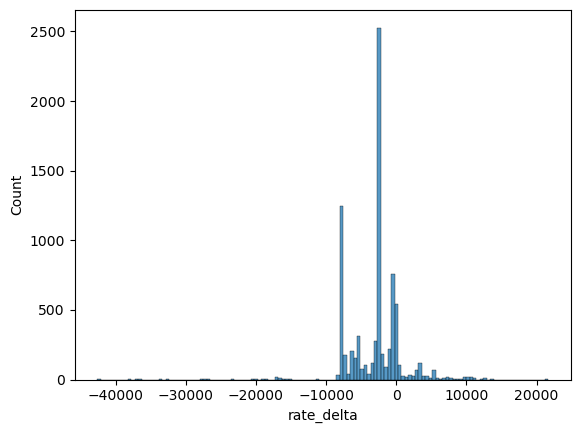

In [436]:
sns.histplot(test_merge2, x='rate_delta')

In [475]:
test_merge2[['rate','hospital_charge', 'rate_delta']].value_counts()

rate      hospital_charge  rate_delta
46.39     2490.00          -2443.61      192
65.70     2490.00          -2424.30      192
168.25    8124.66          -7956.41      192
77.29     2490.00          -2412.71      192
57.96     2490.00          -2432.04      160
                                        ... 
304.72    1246.73          -942.01         1
          1394.79          -1090.07        1
          2513.89          -2209.17        1
          2992.73          -2688.01        1
47574.46  44909.82          2664.64        1
Name: count, Length: 1104, dtype: int64

# Post mortem: 
Well, I'm out of time for coding, and clearly I failed. The matches aren't making a lot of sense, and the deltas are all over the place. There are a number oif problems I ran into:

* I'm not convinced there were enough joinable keys in these two tables to even begin to be certain of correct matches. In theory, for each facility/plan-accepted/procedure combination, there should be a single negotiated rate. I could NOT match on facility here, so I had to match on payer, code type, and raw code--- which results in MULTIPLE rows per combination. (More evidence-there are only 1104 unique combinations of hospital charge and rate here). There could be many reasons for this-- If a hospital owns an outpatient clinic vs a hospital, they may have different staff performing the same procedure, etc. *This would have been remedied by a clear facility-id in the payer table, or a clear plan-id in the hospital table. Something is missing.* This is reinfoirced by the phrasing of your prompt: "The payer extract has the same three billing codes, extracted from three of the largest (Cigna / Aetna / UHC) commercial payers' national PPO files, *for the relevant hospitals*"

*  Because I could not be confident of the matches, and the deltas are all over the place, I really don't have a great idea of how I would interpolate missing values. One thing I am wondering is, given that there are so few actual unique combinations of "rate" and what I got as "hospital charge", it seems the big deltas would be common EVEN if I got the matches right. In hindsight, it seems that the magnitude of delta relative to the size of the rate is very important. I find myself wondering what, exactly, the payer "rate" is. Because if you have a "rate" of 46.39, and a standard_charge_negotiated_dollar that is 50 times larger (of which there are many), I wonder if that rate is multiplied by something to reach the hospital charge. This would be useful information for appropriate metadata for these tables.

*  If I had been confident in the join, and sure of the data, I would have attempted to build distributions of the rates and hospital rates. You could interpolate with a value informed by those distributions, instead of a naive guess like "mean" or "max", which may be heavily skewed. If you had other reliable data for a facility or a payer, you could use that entities tendency to pay more or less relative to other payers/hospitals to inform that decision. 